In [1]:
import requests
import pandas as pd
import time

In [2]:
API_KEY = "961eeb25fa3d34fe88b06c12b361f8ecd36364b0fb2e3321e196b12610e2fd50"
REGION = 11                # 서울로 고정

In [3]:
def fetch_loans(gender, age, startDt, endDt, max_pages=2, retries=3, timeout=20):
    recs = []
    
    for page in range(1, max_pages+1):
        url = (
            f"http://data4library.kr/api/loanItemSrchByLib"
            f"?authKey={API_KEY}&region={REGION}"
            f"&gender={gender}&age={age}"
            f"&startDt={startDt}&endDt={endDt}"
            f"&pageNo={page}&pageSize=100&format=json"
        )
        
        res = None
        for attempt in range(retries):
            try:
                res = requests.get(url, timeout=timeout).json()
                break
            except Exception as e:
                print(f"[재시도 {attempt+1}/{retries}] 실패 age={age}, gender={gender}, page={page}")
                time.sleep(2)
        if res is None: continue
        
        docs = res["response"].get("docs", [])
        if not docs: break
        
        for d in docs:
            doc = d.get("doc", {})
            authors = doc.get("authors", "")
            if "한강" in authors:
                recs.append({
                    "book": doc.get("bookname"),
                    "isbn": doc.get("isbn13"),
                    "authors": authors,
                    "loanCnt": int(doc.get("loan_count", 0)),
                    "gender": gender,
                    "age": age,
                    "period": f"{startDt}_{endDt}"
                })
    return recs

In [4]:
periods = [
    ("2022-01-01","2023-12-31"),   # 노벨상 수상 이전
    ("2024-10-01","2025-03-31")    # 수상 이후
]

ages = [10,20,30,40,50]
genders = [1,2]

In [5]:
records = []

for (startDt,endDt) in periods:
    for gender in genders:
        for age in ages:
            rows = fetch_loans(gender, age, startDt, endDt, max_pages=2)
            records.extend(rows)

[재시도 1/3] 실패 age=50, gender=2, page=2
[재시도 1/3] 실패 age=10, gender=2, page=2
[재시도 1/3] 실패 age=20, gender=2, page=1
[재시도 1/3] 실패 age=20, gender=2, page=2
[재시도 2/3] 실패 age=20, gender=2, page=2
[재시도 1/3] 실패 age=40, gender=2, page=1
[재시도 2/3] 실패 age=40, gender=2, page=1


In [32]:
df = pd.DataFrame(records)
print("데이터 크기:", df.shape)
df.head()

데이터 크기: (128, 7)


,book,isbn,authors,loanCnt,gender,age,period
0,작별하지 않는다 :한강 장편소설,9788954682152,지은이: 한강,5704,1,10,2022-01-01_2023-12-31
1,소년이 온다 :한강 장편소설,9788936434120,지은이: 한강,5042,1,10,2022-01-01_2023-12-31
2,채식주의자:한강 연작소설,9788936433598,한강,4634,1,10,2022-01-01_2023-12-31
3,소년이 온다 :한강 장편소설,9788936434120,지은이: 한강,1574,1,20,2022-01-01_2023-12-31
4,채식주의자:한강 연작소설,9788936433598,한강,1220,1,20,2022-01-01_2023-12-31


In [33]:
summary = df.groupby(["gender","age","period"])["loanCnt"].sum().reset_index()
summary

,gender,age,period,loanCnt
0,1,10,2022-01-01_2023-12-31,15380
1,1,10,2024-10-01_2025-03-31,20441
2,1,20,2022-01-01_2023-12-31,3909
3,1,20,2024-10-01_2025-03-31,2528
4,1,30,2022-01-01_2023-12-31,1976
5,1,30,2024-10-01_2025-03-31,3654
6,1,40,2022-01-01_2023-12-31,1629
7,1,40,2024-10-01_2025-03-31,4976
8,1,50,2022-01-01_2023-12-31,2252
9,1,50,2024-10-01_2025-03-31,6389


In [35]:
pivot = summary.pivot_table(
    index=["gender","age"], 
    columns="period", 
    values="loanCnt",
    fill_value=0
).reset_index()

baseline_col = "2022-01-01_2023-12-31"
after_col    = "2024-10-01_2025-03-31"

pivot["change_rate"] = (pivot[after_col] - pivot[baseline_col]) / pivot[baseline_col].replace(0,1) * 100
pivot


period,gender,age,2022-01-01_2023-12-31,2024-10-01_2025-03-31,change_rate
0,1,10,15380.0,20441.0,32.906372
1,1,20,3909.0,2528.0,-35.328729
2,1,30,1976.0,3654.0,84.919028
3,1,40,1629.0,4976.0,205.463475
4,1,50,2252.0,6389.0,183.703375
5,2,10,697.0,828.0,18.794835
6,2,20,117.0,41.0,-64.957265
7,2,30,39.0,66.0,69.230769
8,2,40,25.0,96.0,284.000000
9,2,50,39.0,113.0,189.743590


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

In [37]:
# 성별 매핑
gender_map = {1: "남성", 2: "여성"}
pivot["gender"] = pivot["gender"].map(gender_map)
df["gender"] = df["gender"].map(gender_map)

# 연령 매핑
age_map = {
    0: "유아",
    6: "초등",
    10: "10대",
    20: "20대",
    30: "30대",
    40: "40대",
    50: "50대",
    60: "60대",
    70: "70대 이상"
}
pivot["age"] = pivot["age"].map(age_map)
df["age"] = df["age"].map(age_map)

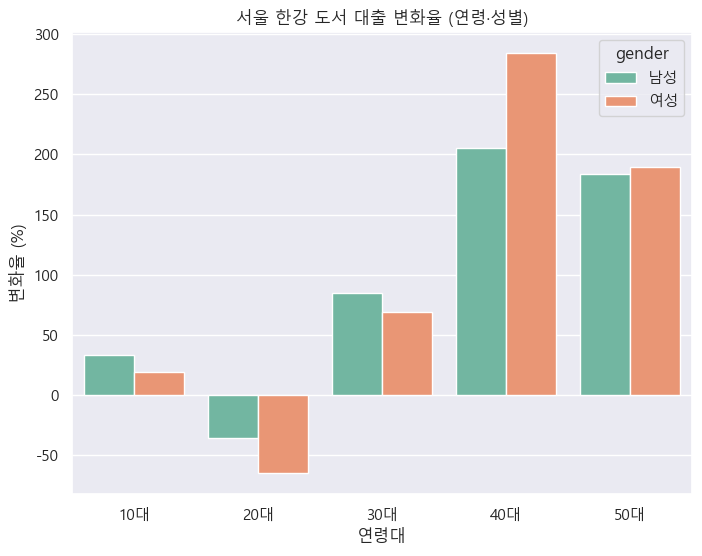

In [38]:
plt.figure(figsize=(8,6))
sns.barplot(x="age", y="change_rate", hue="gender", data=pivot, palette="Set2")
plt.title("서울 한강 도서 대출 변화율 (연령·성별)")
plt.ylabel("변화율 (%)")
plt.xlabel("연령대")
plt.show()

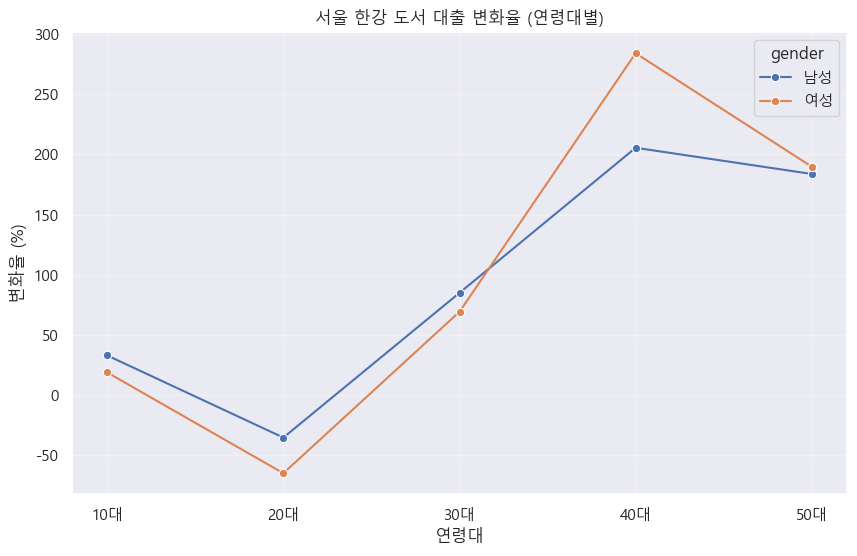

In [39]:
plt.figure(figsize=(10,6))
sns.lineplot(x="age", y="change_rate", hue="gender", data=pivot, marker="o")
plt.title("서울 한강 도서 대출 변화율 (연령대별)")
plt.ylabel("변화율 (%)")
plt.xlabel("연령대")
plt.grid(True, alpha=0.3)
plt.show()

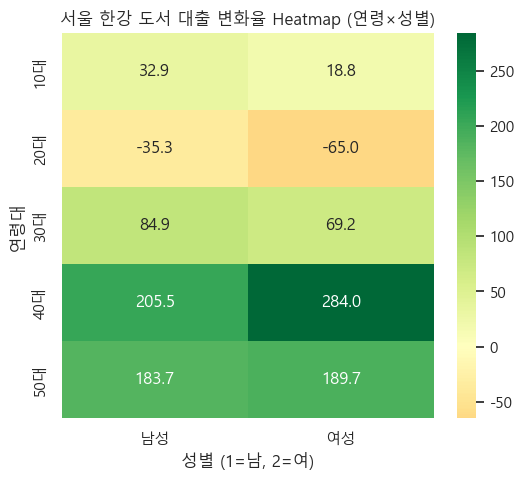

In [40]:
heatmap_data = pivot.pivot(index="age", columns="gender", values="change_rate")

plt.figure(figsize=(6,5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="RdYlGn", center=0)
plt.title("서울 한강 도서 대출 변화율 Heatmap (연령×성별)")
plt.ylabel("연령대")
plt.xlabel("성별 (1=남, 2=여)")
plt.show()